# Propagation des incertitudes dans l'étude d'impact

## Introduction 

L'objectif de cette étude est d'observer un modèle probabiliste dont la sortie est le montant des pensions par rapport aux salaires pour une année donnée. 

Nous considérons le pilotage de la réforme Macron.

* On impose le solde financier de l'étude d'impact, c'est à dire un solde nul à partir de 2027.
* On impose le montant des dépenses de l'étude d'impact, c'est à dire un montant de 14% environ en 2020 vers 12.9% en 2070.
* On impose l'âge de départ en retraite modélisé par une variable aléatoire.

Le niveau des pensions est calculé en sortie du modèle.

Les variables suivantes sont considérées dans le modèle probabiliste.

* Le taux de chômage est considéré comme uniforme entre 4.5% et 10%. 
* Le facteur de report de l'âge de départ en retraite est considéré comme uniforme entre 0.25 et 0.75. 
* L'âge de départ effectif moyen à la retraite est une variable aléatoire uniforme entre l'âge du COR (borne inférieure) et 67 ans (borne supérieure).

L'âge maximal de 67 ans a été choisi pour que la trajectoire d'âge soit supérieure à celle de l'étude d'impact. 

Références : 
* *Projet de loi instituant un système universel de retraite.* - Etude d'impact, 24 janvier 2020
* *Évolutions et perspectives des retraites en France.* Rapport annuel du COR – Juin 2019

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
from retraites.ModelePensionProbabiliste import ModelePensionProbabiliste
from retraites.EtudeImpact import EtudeImpact
import openturns as ot
import pylab as pl
import numpy as np
import openturns.viewer as otv

## Définition des paramètres

In [2]:
simulateur = SimulateurRetraites()

In [3]:
etudeImpact = EtudeImpact(simulateur)
analyse_etudeImpact = etudeImpact.calcule()

In [4]:
analyse_COR = simulateur.pilotageCOR()

## Définition du modèle

In [5]:
def CalculeModeleProbabilisteEtudeImpact(simulateur, analyse_etudeImpact, annee):
    """
    Calcule un modèle probabiliste dans lequel les paramètres sont fixés. 
    Les bornes de la loi uniforme pour l'âge de départ en retraite 
    augmentent progressivement. 
    """
    S = analyse_etudeImpact.S[simulateur.scenario_central][annee]
    D = analyse_etudeImpact.Depenses[simulateur.scenario_central][annee]
    ageMin = analyse_COR.A[simulateur.scenario_central][simulateur.horizon]
    ageMax = 67.0
    modele = ModelePensionProbabiliste(simulateur, annee, S, D, 
                                       bornesAgeConstant = False, 
                                       ageMin = ageMin, ageMax = ageMax)
    return modele

In [6]:
nbannees = len(simulateur.annees_futures)
tableAges = ot.Sample(nbannees, 3)
for i in range(nbannees):
    annee = simulateur.annees_futures[i]
    modele = CalculeModeleProbabilisteEtudeImpact(simulateur, analyse_etudeImpact, annee)
    inputDistribution = modele.getInputDistribution()
    marginaleAge = inputDistribution.getMarginal(0)
    tableAges[i, 0] = annee
    implementation = marginaleAge.getImplementation()
    if implementation.getClassName() == "Dirac":
        parameter = marginaleAge.getParametersCollection()[0]
        tableAges[i, 1] = parameter[0]
        tableAges[i, 2] = parameter[0]
    else:
        parameter = marginaleAge.getParametersCollection()[0]
        tableAges[i, 1] = parameter[0]
        tableAges[i, 2] = parameter[1]

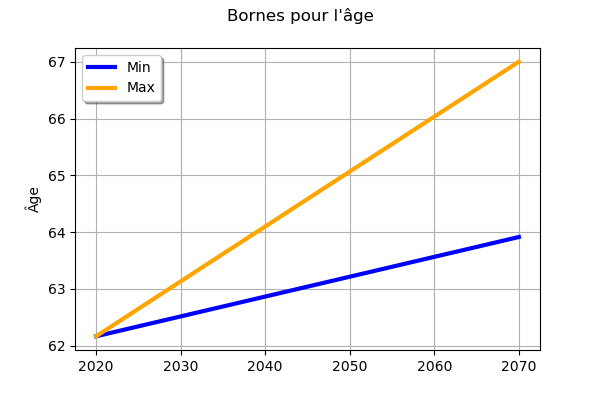

In [7]:
graph = ot.Graph("Bornes pour l'âge","","Âge",True)
curve = ot.Curve(tableAges[:,0], tableAges[:,1])
curve.setLineWidth(3)
graph.add(curve)
curve = ot.Curve(tableAges[:,0], tableAges[:,2])
curve.setLineWidth(3)
curve.setColor("orange")
graph.add(curve)
graph.setLegends(["Min", "Max"])
graph.setLegendPosition("topleft")
graph

Dans notre modèle, l'âge de départ effectif moyen est une variable aléatoire uniforme entre les bornes minimum et maximum. Ce modèle a été choisi pour tenir compte de l'incertitude de l'âge de départ effectif moyen dans le futur. 

Les hypothèses de ce modèle sont les suivantes. 

* L'âge de départ en retraite effectif moyen a tendance à augmenter reflétant les tendances d'augmentation d'espérance de vie.  
* Les bornes minimum et maximum s'éloignent mutuellement reflétant l'augmentation de l'incertitude avec l'éloignement dans le futur. 

## Comparaison entre les bornes de trajectoires d'âge probabilisée et l'étude d'impact

Dans ce paragraphe, nous comparons les bornes d'âge de départ en retraite du modèle avec deux trajectoires différentes :

* la trajectoire de l'âge de départ en retraite du COR,
* la trajectoire de l'âge de départ en retraite de l'étude d'impact. 

L'objectif est de vérifier que le modèle probabiliste de l'âge de départ en retraite recouvre ces trajectoires déterministes. 

In [8]:
scenarios = [simulateur.scenario_central] # Scénario central : Hausse = +1.3% PIB

In [9]:
import openturns.viewer as otv

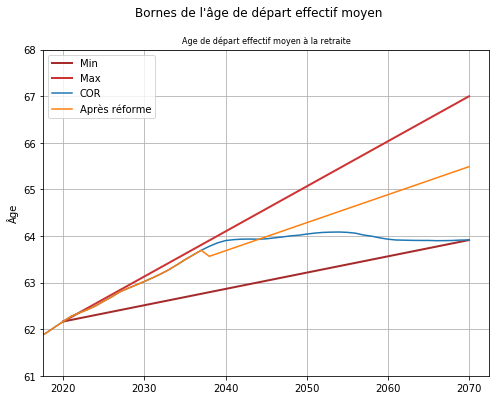

In [10]:
graph = ot.Graph("Bornes de l'âge de départ effectif moyen","","Âge",True)
curve = ot.Curve(tableAges[:,0], tableAges[:,1])
curve.setLineWidth(2)
curve.setColor("brown")
graph.add(curve)
curve = ot.Curve(tableAges[:,0], tableAges[:,2])
curve.setLineWidth(2)
curve.setColor("brown3")
graph.add(curve)
graph.setLegendPosition("topleft")
view = otv.View(graph, figure_kwargs = {"figsize": (8, 6)})
analyse_COR.graphique("A", dessine_legende= False, scenarios_indices = scenarios)
analyse_etudeImpact.graphique("A", dessine_legende= False, scenarios_indices = scenarios)
pl.legend(["Min", "Max", "COR","Après réforme"])
pl.ylim(61.0, 68.0);

On observe que les courbes d'âge de l'étude d'impact et du COR se croisent vers 2044. 
En effet, il y a troix périodes distinctes dans cette trajectoire.
* De 2020 à 2038, l'âge du COR et l'âge de l'étude d'impact sont les mêmes. 
* De 2038 à 2044, l'âge de l'étude d'impact est inférieur à celui du COR. L'étude d'impact prévoit une avance de l'âge de départ à la retraite sur cette période. 
* De 2044 à 2070, l'âge de l'étude d'impact est supérieur à celui du COR. L'étude d'impact prévoit un recul de l'âge de départ à la retraite sur cette période. 

Pour chaque année, les bornes minimales et maximales de la simulation encadrent les trajectoires d'âge du COR et de l'étude d'impact.

## Modèle probabiliste en 2050

In [11]:
annee = 2050
modele = CalculeModeleProbabilisteEtudeImpact(simulateur, analyse_etudeImpact, annee)

Nous souhaitons probabiliser les variables suivantes :
* $A_s$ : l'âge moyen de départ à la retraite défini par l'utilisateur
* $F$ : facteur d'élasticité de report de l'âge de départ (par défaut, $F = 0.5$)
* $\tau_c$ : le taux de chômage

Analysons dans ces conditions la sensibilité du niveau de pension $P_s$  à l'âge moyen de départ à la retraite $A_s$, au facteur d'élasticité $F$ et au taux de chômage $\tau_c$.

In [12]:
fonctionPension = modele.getFonction()
fonctionPension

class=FunctionImplementation name=Unnamed description=[As,F,TauC,P] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.129] input positions=[2,3,4] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.129] input positions=[2,3,4] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.129] input positions=[2,3,4]

In [13]:
inputDescription = fonctionPension.getInputDescription()
inputDescription

[As,F,TauC]

In [14]:
fonctionPension.getOutputDescription()

[P]

In [15]:
fonctionPension.getParameterDescription()

[S,D]

In [16]:
inputDistribution = modele.getInputDistribution()
inputDimension = inputDistribution.getDimension()
inputDimension

3

In [17]:
for i in range(inputDimension):
    print(inputDescription[i], inputDistribution.getMarginal(i))

As Uniform(a = 63.2141, b = 65.0661)
F Uniform(a = 0.25, b = 0.75)
TauC Uniform(a = 4.5, b = 10)


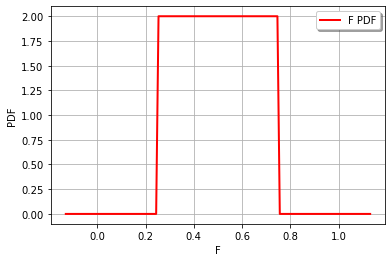

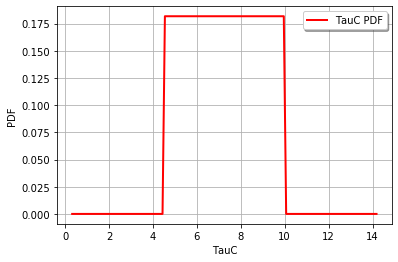

In [18]:
for i in [1, 2]:
    marginale = inputDistribution.getMarginal(i)
    graph = marginale.drawPDF()
    view = otv.View(graph)

Dans ce modèle, les distributions de F et TauC sont constantes et ne dépendent pas de l'année.

## Modèle probabiliste de l'âge en fonction de l'année

Dans ce paragraphe, nous analysons le modèle probabiliste de l'âge de départ en retraite en fonction de l'année. L'objectif est d'observer l'évolution de la distribution de l'âge dans notre modèle. 

In [19]:
def createHSVColor(indexCurve,maximumNumberOfCurves):
    '''Create a HSV color for the indexCurve-th curve
    from a sample with maximum size equal to maximumNumberOfCurves'''
    color = ot.Drawable.ConvertFromHSV(indexCurve * 360.0/maximumNumberOfCurves, 1.0, 0.9)
    return color

In [20]:
graph = ot.Graph("Loi de l'âge de départ en retraite effectif moyen", "Age", 'PDF', True)

2020
2025
2030
2040
2050
2060
2070


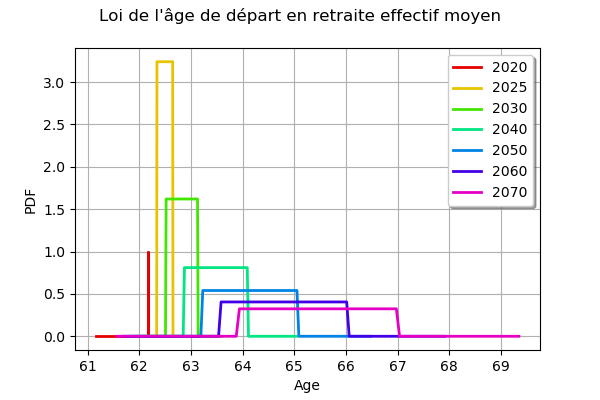

In [21]:
nbannees = len(simulateur.annees_standard)
tableAges = ot.Sample(nbannees, 3)
for i in range(nbannees):
    annee = simulateur.annees_standard[i]
    print(annee)
    modele = CalculeModeleProbabilisteEtudeImpact(simulateur, analyse_etudeImpact, annee)
    inputDistribution = modele.getInputDistribution()
    marginaleAge = inputDistribution.getMarginal(0)
    graphPDF = marginaleAge.drawPDF()
    graphPDF.setColors([createHSVColor(i,nbannees)])
    graph.add(graphPDF)
graph.setLegends([str(a) for a in simulateur.annees_standard])
graph.setLegendPosition("topright")
graph

On observe que la loi de l'âge de départ en retraite est uniforme pour chaque année. La tendance moyenne est à l'augmentation de l'âge de départ en retraite. De plus, ce modèle impose que les bornes de la loi uniforme s'écartent mutuellement dans le futur. 

## Analyse en tendance centrale en 2050

Dans ce paragraphe, nous analysons la distribution des pensions de retraite en 2050, compte tenu des incertitudes sur l'âge de départ, le facteur de report de l'âge de départ et le taux de chômage. 

In [22]:
def GenereEchantillonMonteCarloPension(simulateur, analyse_etudeImpact, annee, tailleEchantillon):
    """
    Génère un échantillon de P de taille donnée sur un plan Monte-Carlo simple.
    """
    # Crée le modèle
    modele = CalculeModeleProbabilisteEtudeImpact(simulateur, analyse_etudeImpact, annee)
    inputDistribution = modele.getInputDistribution()
    fonctionPension = modele.getFonction()
    # Crée le vecteur aléatoire
    inputRandomVector = ot.RandomVector(inputDistribution)
    outputRandomVector = ot.CompositeRandomVector(fonctionPension, inputRandomVector)
    # Génère l'échantillon
    echantillonPension = outputRandomVector.getSample(tailleEchantillon)
    return echantillonPension

In [23]:
annee = 2050
tailleEchantillon = 10000
echantillonPension = GenereEchantillonMonteCarloPension(simulateur, analyse_etudeImpact, annee, tailleEchantillon)

In [24]:
kernel = ot.KernelSmoothing()
fittedDist = kernel.build(echantillonPension)

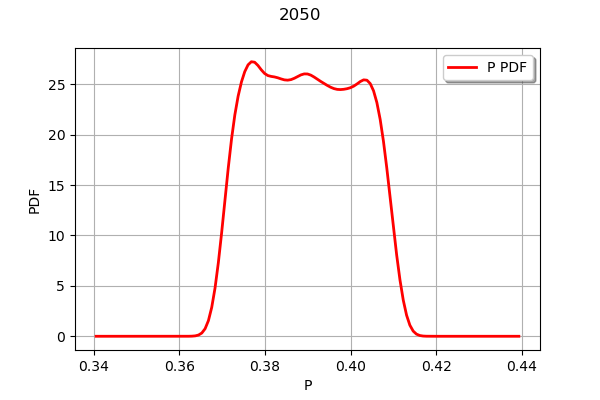

In [25]:
graph = fittedDist.drawPDF()
graph.setTitle("%d" % (annee))
graph

On observe que la distribution des pensions moyennes brut par rapport aux salaires se situe entre 0.36 et 0.42 environ. 

In [26]:
alpha = 0.95
fittedDist.computeBilateralConfidenceInterval(alpha)

class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[0.370511] upper bound=class=Point name=Unnamed dimension=1 values=[0.409587] finite lower bound=[1] finite upper bound=[1]

Le modèle prédit que, avec une probabilité égale à 95%, le montant des pensions est entre 37% et 41% en 2050.  

## Utilisation d'une séquence à faible discrépance

Dans ce paragraphe, nous utilisons une séquence à faible discrépance pour générer un échantillon de pensions. Nous utilisons une séquence de Sobol'. 

In [27]:
def GenereEchantillonSobolPension(simulateur, analyse_etudeImpact, annee, tailleEchantillon):
    """
    Génère un échantillon de P de taille donnée sur un plan d'expériences à 
    faible discrépance de type séquence de Sobol'.
    """
    # Crée le modèle
    modele = CalculeModeleProbabilisteEtudeImpact(simulateur, analyse_etudeImpact, annee)
    inputDistribution = modele.getInputDistribution()
    fonctionPension = modele.getFonction()
    # Crée le plan d'expériences
    inputDimension = inputDistribution.getDimension()
    sequence = ot.SobolSequence(inputDimension)
    experiment = ot.LowDiscrepancyExperiment(sequence, inputDistribution, tailleEchantillon)
    echantillonEntree = experiment.generate()
    # Génère l'échantillon
    echantillonPension = fonctionPension(echantillonEntree)
    return echantillonPension

In [28]:
annee = 2050
tailleEchantillon = 1000
echantillonPension = GenereEchantillonSobolPension(simulateur, analyse_etudeImpact, annee, tailleEchantillon)

In [29]:
kernel = ot.KernelSmoothing()
fittedDist = kernel.build(echantillonPension)

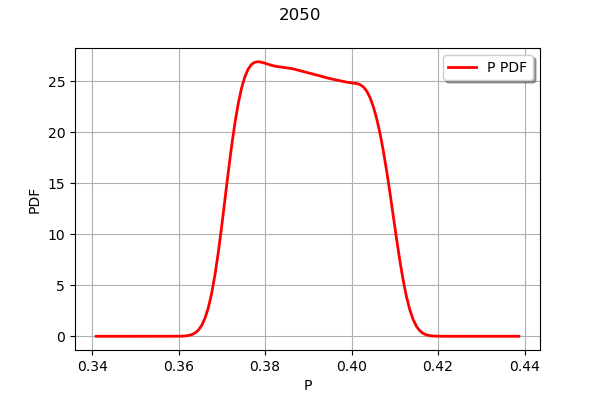

In [30]:
graph = fittedDist.drawPDF()
graph.setTitle("%d" % (annee))
graph

## Sensibilité à l'année

Dans ce paragraphe, nous analysons la sensibilité de la distribution de la pension en fonction de l'année. Pour calculer la distribution, nous utilisons un plan d'expériences de type Monte-Carlo simple de taille 10 000. La distribution est estimée sur l'échantillon avec une méthode d'estimation à noyau. 

In [31]:
title = "Distribution de (pension moyenne) / (salaire moyen)"
xTitle = "P"
yTitle = "PDF" 
showAxes = True
tailleEchantillon = 1000
nb_annees = len(simulateur.annees_standard)
sampleP_list = [] # Liste des échantillons de P en fonction de l'année
distributionP_list = [] # Liste des distributions de P en fonction de l'année
for i in range(nb_annees):
    annee = simulateur.annees_standard[i]
    print(annee)
    echantillonPension = GenereEchantillonSobolPension(simulateur, analyse_etudeImpact, annee, tailleEchantillon)
    sampleP_list.append(echantillonPension)
    kernel = ot.KernelSmoothing()
    fittedDist = kernel.build(echantillonPension)
    distributionP_list.append(fittedDist)

2020
2025
2030
2040
2050
2060
2070


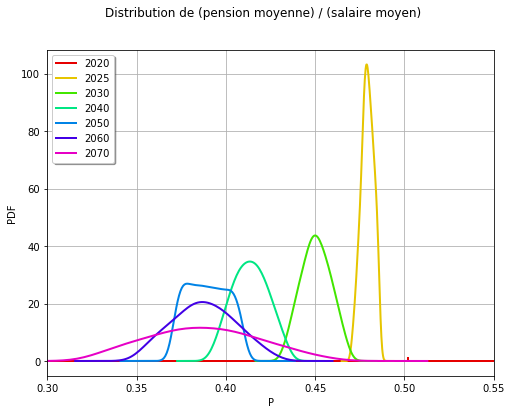

In [32]:
graph = ot.Graph(title, xTitle, yTitle, showAxes)
for i in range(nb_annees):
    annee = simulateur.annees_standard[i]
    fittedDist = distributionP_list[i]
    pdfP = fittedDist.drawPDF()
    pdfP.setColors([createHSVColor(i,nb_annees)])
    graph.add(pdfP)
graph.setLegends([str(a) for a in simulateur.annees_standard])
graph.setLegendPosition("topleft")
view = otv.View(graph, figure_kwargs = {"figsize": (8, 6)})
pl.xlim(xmin = 0.30, xmax = 0.55);

On observe que la distribution de la pension se décale progressivement vers la gauche dans le futur. 

* En 2025, l'incertitude sur le niveau de pension est faible. La distribution est centrée sur 0.48 et peu dispersée. 
* Entre 2030 et 2050, la distribution se déplace et elle est centrée sur 0.37 en 2050, avec une dispersion plus grande.
* Entre 2050 et 2070, la distribution reste centrée sur 0.37 mais sa dispersion augmente. 

## Intervalle de confiance de P en fonction de l'année

Dans ce paragraphe, nous souhaitons calculer l'intervalle de confiance du niveau des pensions par rapport aux salaires en fonction de l'année. Nous considérons un intervalle de confiance bilatéral de niveau 95%. Compte tenu de la taille de l'échantillon que nous avons utilisé pour générer l'échantillon, c'est à dire 10 000 simulations, l'analyse en tendance centrale est légitime et les intervalles de confiances sont relativement précis, avec près de 2 chiffres significatifs. 

In [33]:
alpha = 0.95
intervals_list = []
print("Intervalle de confiance sur P de niveau %.2f %%" % (100.0 * alpha))
for i in range(nb_annees):
    annee = simulateur.annees_standard[i]
    fittedDist = distributionP_list[i]
    pdfP = fittedDist.drawPDF()
    interval = fittedDist.computeBilateralConfidenceInterval(alpha)
    lower = 100.0 * interval.getLowerBound()[0]
    upper = 100.0 * interval.getUpperBound()[0]
    print("%d : [%.1f %%, %.1f %%]" % (annee, lower, upper))
    intervals_list.append(interval)

Intervalle de confiance sur P de niveau 95.00 %
2020 : [50.2 %, 50.2 %]
2025 : [47.2 %, 48.6 %]
2030 : [43.4 %, 46.7 %]
2040 : [39.4 %, 43.3 %]
2050 : [37.0 %, 41.0 %]
2060 : [35.4 %, 42.3 %]
2070 : [32.9 %, 44.9 %]


Dans le graphique suivant, on représente l'intervalle de confiance de niveau 95% des pensions en fonction de l'année. 

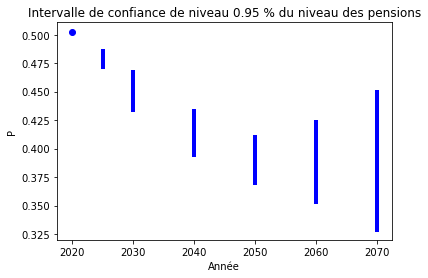

In [34]:
pl.xlabel("Année")
pl.ylabel("P")
pl.title("Intervalle de confiance de niveau %.2f %% du niveau des pensions" % (alpha))
P2020 = analyse_COR.P[simulateur.scenario_central][simulateur.annee_courante]
pl.plot(simulateur.annees_standard[0], P2020, "bo")
for i in range(nb_annees):
    annee = simulateur.annees_standard[i]
    interval = intervals_list[i]
    lower = interval.getLowerBound()[0]
    upper = interval.getUpperBound()[0]
    pl.plot([annee, annee], [lower, upper], "b-", linewidth=4.0)

## Evolution de la dispersion en fonction de l'année

Pour représenter les boîtes à moustage, on prépare les données sous la forme d'une liste de `array` Numpy de dimension 1. 

In [35]:
annees_ticks = [simulateur.annees_standard[i] for i in range(nb_annees)] 
annees_ticks

[2020, 2025, 2030, 2040, 2050, 2060, 2070]

In [36]:
data = []
for i in range(nb_annees):
    sample = np.array(sampleP_list[i]).flatten()
    data.append(sample)

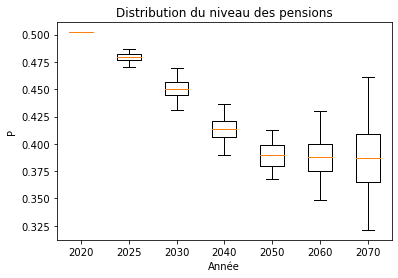

In [37]:
pl.title("Distribution du niveau des pensions")
pl.xlabel("Année")
pl.ylabel("P")
pl.boxplot(data);
pl.xticks(range(1, nb_annees + 1), annees_ticks);

On observe que l'évolution des boîtes à moustache en fonction de l'année présente deux caractéristiques principales. 

* D'une part, la tendance de l'évolution des pensions à la baisse est nette, avec un niveau de pension égal à 0.50 en 2020 et un niveau de pension proche de 0.40 en 2070. 
* D'autre part une augmentation de la dispersion de la distribution dans le futur, avec une forte dispersion en 2070.